# Deutsch-Jozsa Algorithm with Imperative Computation (AutoQASM)

This notebook will introduce the Deutsch-Joszsa problem and solution. We then implement the quantum solution with AutoQASM, demonstrating it's success by submitting quantum jobs to qBraid's QIR simulator.

## Introduction

### The Problem
We are given a hidden decision function $f: \mathbb \{0, 1\}^n \to \{0, 1\}$. For this problem, we assume any such $f$ is either "balanced" or "constant". 
- Balanced: $f$ returns $0$'s on exactly $2^{n-1}$ of the possible inputs, and $1$'s on the other $2^{n-1}$.
- Constant: $f(x) = 0$ or $f(x) = 1$ for all $x \in \{0, 1\}^n$. 

The Deutch-Jozsa problem is to determine, given a function $f$, to determine whether it is in fact balanced or constant.

### The Classical Deterministic Solution

By doing a worst-case analysis on the problem, it is easy to see that we would require $2^{n-1} + 1$ calls to $f$ to solve this problem. There are probabilistic classical alternatives that use less calls.

### The Classical Probabilistic Solution

Given that a function is balanced where the inputs are uniformly chosen to have output $0$ or $1$, there is a $\dfrac{1}{2^{n-1}}$ probability that we actually have to query $f$ $2^{n-1}+1$ times. This hints at a probabilistic solution to the problem.

The solution is the choose $k$ random inputs, from which we can derive $$P_{\text{constant}}(k) = 1- \frac{1}{2^{k-1}}.$$

Basically, we can run the classical deterministic solution and just break whenever we have, say, $p$ probability of confidence.

### The Quantum Solution

A quantum computer can solve the Deutsch-Jozsa problem with 100% confidence with only ***one*** call to $f$. The actual circuit has $n+1$ qubits ($n \ket{0}$ 's and $1 \ket{1}$) and is split into four main parts:
1. Preparing the quantum registers: The first $n$-qubit register are set to $\ket{0}^{\otimes n}$ and the second as $\ket 1$: $$\ket {\psi_0} = \ket 0 ^{\otimes n} \ket 1.$$
2. Applying a Hadamard gate to all qubits: $$\ket{\psi_{1}} = \frac{1}{\sqrt{2^{n+1}}} \sum_{x=0}^{2^n-1} \ket x (\ket 0 - \ket 1).$$
3. Appling the quantum oracle $U_f: \ket x \ket y \mapsto \ket x \ket{y \oplus f(x)}$: $$\ket{\psi_2} = \frac{1}{\sqrt{2^n+1}} \sum_{x=0}^{2^n-1} (-1)^{f(x)}\ket x (\ket 0 - \ket 1)$$
4. Applying a Hadamard gate to the first $n$ qubits: $$\ket{\psi_3} = \frac{1}{2^n} \sum_{y=0}^{2^n-1} \left[\sum_{x=0}^{2^n-1} (-1)^{f(x)} (-1)^{x\cdot y}\right] \ket y $$

Now, we just measure the first register. We see that: $$P(\ket{0}^{\otimes n}) = \left| \frac{1}{2^n} \sum_{x=0}^{2^n - 1} (-1)^{f(x)} \right|^2,$$
which is 1 *if and only if* $f$ is constant. This suffices to show correctness of our solution.

#### The Oracle
**Constant Oracle**

When a oracle is constant, it has no effect on the input qubits. So step 4 reverses step 2, giving us the same vector we had after step 1. 

**Balanced Oracle**

Step 2 gives us an $x$ that is an equal superposition of all states in the $n$-qubit basis. A balanced oracle has a phase kickback that gives negative phase to exactly half of the states. The state after applying the oracle is orthogonal to the prior state, meaning applying $n$ Hadamard gates yields a state orthogonal to $\ket{00\ldots 0}$. 

## AutoQASM Implementation

We start by importing the relevant libraries.

In [1]:
import numpy as np
import autoqasm as aq
import autoqasm.instructions as ins

from qbraid.programs import QPROGRAM_REGISTRY, register_program_type
from qbraid.runtime.native import QbraidProvider
from qbraid.transpiler import Conversion, ConversionGraph
from qbraid.visualization.plot_counts import plot_histogram

from qbraid_qir.autoqasm.convert import autoqasm_to_qasm3

### Constant Example

For this example, we're gonna use a four qubit example. We start by identifying that the oracle is going to just be the identity, as a valid $U_f: \ket x \ket y \mapsto \ket x \ket{y \oplus 0} = \ket x \ket y$ is the identity mapping.

In [3]:
n = 4

In [4]:
def constant_f(x):
    return 0

@aq.gate
def constant_oracle(q1: aq.Qubit, q2: aq.Qubit, q3: aq.Qubit, q4: aq.Qubit, q5: aq.Qubit):
    pass

@aq.main(num_qubits=n+1)
def deutch_jozsa_constant():
    ins.x(4)
    for i in range(n+1):
        ins.h(i)

    constant_oracle(*range(n+1))
    
    for i in range(n+1):
        ins.h(i)
    
    for i in range(n):
        ins.measure(i)

## qBraid Instructions

qBraid providers a QIR Simulator for quantum jobs. To demonstrate its usage, we'll be using it to simulate the Deutsch-Jozsa algorithm. Since we wrote the algorithm using AutoQASM, we start by adding AutoQASM programs to the `QPROGRAM_REGISTRY`. Then, since we have a function that takes AutoQASM programs to qasm3, we'll add that conversion to the `ConversionGraph`. 

In [6]:
register_program_type(aq.program.MainProgram)
QPROGRAM_REGISTRY

{'cirq': cirq.circuits.circuit.Circuit,
 'qiskit': qiskit.circuit.quantumcircuit.QuantumCircuit,
 'pennylane': pennylane.tape.tape.QuantumTape,
 'pyquil': pyquil.quil.Program,
 'pytket': pytket._tket.circuit.Circuit,
 'braket': braket.circuits.circuit.Circuit,
 'openqasm3': openqasm3.ast.Program,
 'pyqir': Module,
 'qasm2': str,
 'qasm3': str,
 'autoqasm': autoqasm.program.program.MainProgram}

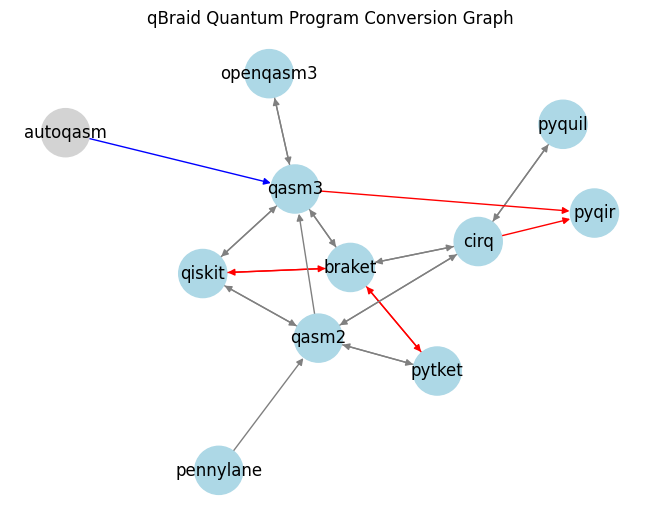

In [7]:
graph = ConversionGraph() 

aq_qasm3_conversion = Conversion("autoqasm", "qasm3", autoqasm_to_qasm3)

graph.add_conversion(aq_qasm3_conversion)

graph.plot()

We now see that qBraid recognizes AutoQASM programs and will be able it to transpile it to qasm3, which will then be translated to QIR. 

Now, we set up the QIR Simulator.

In [8]:
provider = QbraidProvider()
provider.get_devices()

[<qbraid.runtime.native.device.QbraidDevice('qbraid_qir_simulator')>]

In [9]:
device = provider.get_device('qbraid_qir_simulator')
device.status()

<DeviceStatus.ONLINE: 'online'>

To ensure the device knows how to compile an AutoQASM program, we update the device scheme directly.

In [10]:
device.update_scheme(conversion_graph=graph)

In [11]:
job = device.run(deutch_jozsa_constant)

In [12]:
res = job.result()

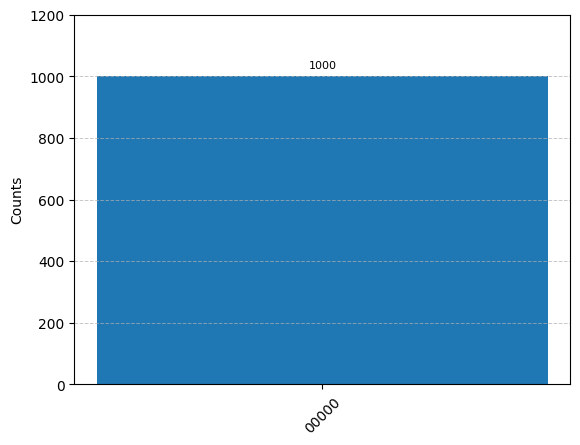

In [13]:
plot_histogram(res.measurement_counts())

As we can see, the algorithm returns $\ket{00000}$ 100% of the time, implying that our $f$ is constant. 

Now we consider a balanced $f$. The f we will use is given by $$f(x) = \begin{cases} 0 & x \in [0, 7] \\ 1 & x \in [8, 15]\end{cases}.$$

To construct $U_f$ that suffices $\ket x \ket y \mapsto \ket x \ket{y \oplus f(x)}$, we consider when $f(x) = 1$, which is exactly when the most significant bit (MSB) is also equal to 1. As such, our oracle just uses a controlled-NOT gate where the control qubit is the MSB of $x$ adn the target bit is $y$. 

In [14]:
def balanced_f(x):
    if x in range(0, 2**n / 2):
        return 0
    return 1

@aq.gate
def balanced_oracle(q0: aq.Qubit, q1: aq.Qubit, q2: aq.Qubit, q3: aq.Qubit, q4: aq.Qubit):
    ins.cnot(q3, q4)

@aq.main(num_qubits=n+1)
def deutch_jozsa_balanced():
    ins.x(4)
    for i in range(n+1):
        ins.h(i)

    balanced_oracle(*range(n+1))
    
    for i in range(n+1):
        ins.h(i)
    
    for i in range(n):
        ins.measure(i)

In [ ]:
job = device.run(deutch_jozsa_balanced)

In [16]:
res = job.result()

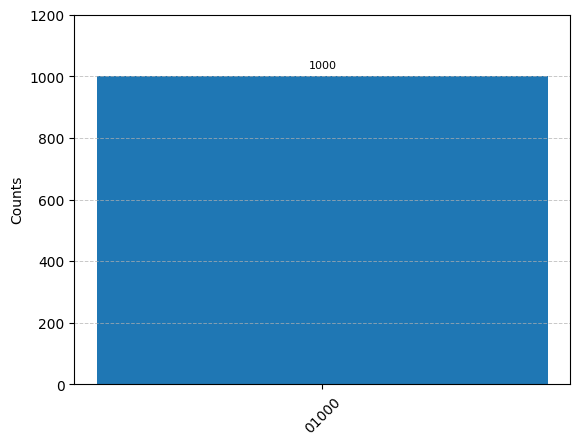

In [17]:
plot_histogram(res.measurement_counts())

We see here that the probability of measuring $\ket{00000}$ is 0. This correctly predicts that our $f$ is balanced.